# Trend analysis in Python

Bruno Montibeller & Holger Virro

Department of Geography

University of Tartu

## Introduction

General introduction of the workshop
* Main goal: using Python to apply trend analysis on NetCDF data
* Trend analysis basics: what it can be used for
* MK test: why it is used for this type of analysis, benefits over other methods

Data description
* Monthly precipitation (and temperature) data for the Baltic states

Tools
* Python libraries xarray, pandas, pymannkendall and matplotlib

List main steps before going on with the coding?
* Reading NetCDF
* Converting it into a Pandas DF
* Grouping data by location and month
* Calculating trend parameters
* Visualizing results

In [1]:
# Import libraries
import os
import xarray as xr
import pandas as pd
import numpy as np
import pymannkendall as mk
import rasterio
import matplotlib.pyplot as plt
import cartopy

In [2]:
# Data directory
data_dir = 'C:/Users/Holger/EGU2021/SC5.8/data'

In [3]:
# Import monthly precipitation data
precip_fp = os.path.join(data_dir, 'monthly_precip_baltics.nc')
precip_ds = xr.open_dataset(precip_fp)
precip_ds

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, time: 240)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2020-12-31
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
    spatial_ref  int32 ...
Data variables:
    precip_sum   (time, latitude, longitude) float32 ...

In [4]:
# Convert the xarray to Pandas dataframe
precip_df = precip_ds.to_dataframe().reset_index()
precip_df

,latitude,longitude,time,spatial_ref,precip_sum
0,53.949860,21.04986,2001-01-31,0,NaN
1,53.949860,21.04986,2001-02-28,0,NaN
2,53.949860,21.04986,2001-03-31,0,NaN
3,53.949860,21.04986,2001-04-30,0,NaN
4,53.949860,21.04986,2001-05-31,0,NaN
...,...,...,...,...,...
984955,59.549859,28.14986,2020-08-31,0,NaN
984956,59.549859,28.14986,2020-09-30,0,NaN
984957,59.549859,28.14986,2020-10-31,0,NaN
984958,59.549859,28.14986,2020-11-30,0,NaN


In [5]:
# Drop rows with missing precipitation values
precip_df = precip_df.dropna().reset_index()
precip_df

,index,latitude,longitude,time,spatial_ref,precip_sum
0,6000,53.949860,23.54986,2001-01-31,0,32.099998
1,6001,53.949860,23.54986,2001-02-28,0,22.000000
2,6002,53.949860,23.54986,2001-03-31,0,39.799999
3,6003,53.949860,23.54986,2001-04-30,0,32.400002
4,6004,53.949860,23.54986,2001-05-31,0,57.200005
...,...,...,...,...,...,...
611215,980635,59.549859,26.34986,2020-08-31,0,68.700005
611216,980636,59.549859,26.34986,2020-09-30,0,38.700001
611217,980637,59.549859,26.34986,2020-10-31,0,42.400002
611218,980638,59.549859,26.34986,2020-11-30,0,40.200001


In [6]:
# Extract month from the observation date as a new column
precip_df['month'] = precip_df['time'].dt.strftime('%m')
precip_df

,index,latitude,longitude,time,spatial_ref,precip_sum,month
0,6000,53.949860,23.54986,2001-01-31,0,32.099998,01
1,6001,53.949860,23.54986,2001-02-28,0,22.000000,02
2,6002,53.949860,23.54986,2001-03-31,0,39.799999,03
3,6003,53.949860,23.54986,2001-04-30,0,32.400002,04
4,6004,53.949860,23.54986,2001-05-31,0,57.200005,05
...,...,...,...,...,...,...,...
611215,980635,59.549859,26.34986,2020-08-31,0,68.700005,08
611216,980636,59.549859,26.34986,2020-09-30,0,38.700001,09
611217,980637,59.549859,26.34986,2020-10-31,0,42.400002,10
611218,980638,59.549859,26.34986,2020-11-30,0,40.200001,11


In [7]:
# Group locations by month and collect observation values to NumPy array
precip_group_df = precip_df.groupby(['latitude', 'longitude', 'month'])['precip_sum'].apply(np.array).reset_index()
precip_group_df

,latitude,longitude,month,precip_sum
0,53.949860,23.54986,01,"[32.1, 45.500008, 26.5, 40.999996, 52.4, 11.9,..."
1,53.949860,23.54986,02,"[22.0, 63.7, 18.1, 44.800003, 22.7, 39.5, 31.0..."
2,53.949860,23.54986,03,"[39.8, 26.1, 10.5, 37.2, 35.699997, 13.900001,..."
3,53.949860,23.54986,04,"[32.4, 13.200001, 29.500002, 38.5, 18.199999, ..."
4,53.949860,23.54986,05,"[57.200005, 34.9, 62.8, 58.300003, 77.9, 45.19..."
...,...,...,...,...
30559,59.549859,26.34986,08,"[60.800003, 11.6, 115.799995, 82.80001, 91.399..."
30560,59.549859,26.34986,09,"[43.5, 12.200001, 40.300003, 92.00001, 30.2, 3..."
30561,59.549859,26.34986,10,"[74.7, 36.600002, 58.3, 53.4, 36.5, 100.59999,..."
30562,59.549859,26.34986,11,"[70.200005, 78.100006, 51.100002, 56.1, 51.4, ..."


In [8]:
precip_array = precip_group_df['precip_sum'].to_numpy()
precip_array

array([array([32.1     , 45.500008, 26.5     , 40.999996, 52.4     , 11.9     ,
       81.200005, 49.5     , 36.500004, 26.400002, 27.700003, 51.500004,
       38.500004, 58.4     , 56.2     , 27.499998, 21.499998, 36.3     ,
       45.6     , 39.8     ], dtype=float32),
       array([22.      , 63.7     , 18.1     , 44.800003, 22.7     , 39.5     ,
       31.      , 23.      , 31.300001, 35.2     , 49.2     , 27.199999,
       31.999998, 23.000002,  8.      , 57.200005, 32.600002, 12.3     ,
       16.300001, 43.6     ], dtype=float32),
       array([39.8     , 26.1     , 10.5     , 37.2     , 35.699997, 13.900001,
       23.599998, 58.1     , 45.7     , 25.6     , 16.1     , 22.8     ,
       27.800001, 32.9     , 43.      , 46.200005, 61.300007, 23.9     ,
       40.3     , 19.6     ], dtype=float32),
       ...,
       array([ 74.7     ,  36.600002,  58.3     ,  53.4     ,  36.5     ,
       100.59999 ,  59.699997,  68.5     , 120.7     ,  45.6     ,
        54.000004,  82.200005, 

In [9]:
precip_dict = {}
precip_dict['trend'] = []
precip_dict['slope'] = []
for array in precip_array:
    result = mk.original_test(array)
    precip_dict['trend'].append(result.trend)
    precip_dict['slope'].append(result.slope)

In [10]:
precip_group_df['trend'] = precip_dict['trend']
precip_group_df['slope'] = precip_dict['slope']
display(precip_group_df['trend'].value_counts())
display(precip_group_df['slope'].describe())
display(precip_group_df)

no trend      30384
increasing      142
decreasing       38
Name: trend, dtype: int64

count    30564.000000
mean        -0.168654
std          0.828888
min         -3.290909
25%         -0.705000
50%         -0.085714
75%          0.368914
max          4.058333
Name: slope, dtype: float64

,latitude,longitude,month,precip_sum,trend,slope
0,53.949860,23.54986,01,"[32.1, 45.500008, 26.5, 40.999996, 52.4, 11.9,...",no trend,0.113462
1,53.949860,23.54986,02,"[22.0, 63.7, 18.1, 44.800003, 22.7, 39.5, 31.0...",no trend,-0.379048
2,53.949860,23.54986,03,"[39.8, 26.1, 10.5, 37.2, 35.699997, 13.900001,...",no trend,0.433333
3,53.949860,23.54986,04,"[32.4, 13.200001, 29.500002, 38.5, 18.199999, ...",no trend,0.603571
4,53.949860,23.54986,05,"[57.200005, 34.9, 62.8, 58.300003, 77.9, 45.19...",no trend,-0.925000
...,...,...,...,...,...,...
30559,59.549859,26.34986,08,"[60.800003, 11.6, 115.799995, 82.80001, 91.399...",no trend,-0.416667
30560,59.549859,26.34986,09,"[43.5, 12.200001, 40.300003, 92.00001, 30.2, 3...",no trend,0.793750
30561,59.549859,26.34986,10,"[74.7, 36.600002, 58.3, 53.4, 36.5, 100.59999,...",no trend,-0.075000
30562,59.549859,26.34986,11,"[70.200005, 78.100006, 51.100002, 56.1, 51.4, ...",no trend,-1.059722


In [11]:
precip_group_df['trend_numeric'] = precip_group_df['trend'].apply(lambda x: -1 if x == 'decreasing' else (1 if x == 'increasing' else 0))
display(precip_group_df.sample(10))
display(precip_group_df['trend_numeric'].value_counts())

,latitude,longitude,month,precip_sum,trend,slope,trend_numeric
24018,58.249859,24.54986,07,"[82.9, 116.0, 43.800003, 56.899998, 64.8, 12.9...",no trend,-0.924243,0
9132,55.949859,23.64986,01,"[20.600002, 54.9, 23.7, 21.900002, 40.0, 21.10...",no trend,0.805883,0
13878,56.449859,28.14986,07,"[62.2, 13.8, 95.50001, 33.7, 40.5, 31.7, 96.29...",increasing,2.679165,1
24481,58.349859,22.94986,02,"[45.5, 60.900005, 4.2, 39.2, 13.6, 19.5, 24.5,...",no trend,0.323333,0
19482,57.249859,22.94986,07,"[112.19999, 98.299995, 25.9, 75.600006, 80.3, ...",no trend,-2.054894,0
6278,55.549859,23.04986,03,"[41.3, 44.4, 7.0, 68.100006, 41.5, 23.699999, ...",no trend,-0.277778,0
17821,56.949859,26.44986,02,"[66.0, 61.199997, 18.9, 51.2, 13.9, 18.2, 31.9...",no trend,-0.016667,0
26418,58.649859,26.14986,07,"[87.799995, 55.899998, 64.8, 76.2, 48.100002, ...",no trend,-0.418938,0
22361,57.849859,24.64986,06,"[50.399994, 104.79999, 35.199997, 110.90001, 7...",no trend,0.607143,0
11372,56.249859,21.64986,09,"[111.4, 45.5, 41.7, 93.700005, 20.6, 31.900002...",no trend,-0.329167,0


 0    30384
 1      142
-1       38
Name: trend_numeric, dtype: int64

In [12]:
subset = precip_group_df[precip_group_df['month'] == '09']
subset

,latitude,longitude,month,precip_sum,trend,slope,trend_numeric
8,53.949860,23.54986,09,"[103.00001, 16.4, 31.0, 24.600002, 32.9, 51.6,...",no trend,0.259127,0
20,53.949860,23.64986,09,"[99.600006, 17.000002, 31.8, 25.199999, 33.0, ...",no trend,0.310714,0
32,53.949860,23.74986,09,"[99.1, 17.0, 34.2, 25.2, 33.4, 49.8, 32.7, 46....",no trend,0.046591,0
44,53.949860,24.04986,09,"[95.39999, 19.0, 29.2, 26.8, 32.0, 48.200005, ...",no trend,0.378889,0
56,53.949860,24.34986,09,"[89.399994, 19.3, 26.6, 29.1, 29.6, 54.000004,...",no trend,0.411111,0
...,...,...,...,...,...,...,...
30512,59.549859,25.94986,09,"[48.1, 8.0, 49.7, 92.200005, 27.6, 30.800001, ...",no trend,1.448931,0
30524,59.549859,26.04986,09,"[47.899998, 9.400001, 49.7, 92.0, 29.3, 31.800...",no trend,1.413889,0
30536,59.549859,26.14986,09,"[46.4, 10.6, 52.7, 94.4, 28.900002, 32.4, 103....",no trend,0.924167,0
30548,59.549859,26.24986,09,"[45.199997, 12.3, 45.2, 92.4, 32.2, 31.7, 99.1...",no trend,0.973016,0


In [13]:
test_df = precip_group_df.copy()
test_df.set_index(['latitude', 'longitude', 'month'], inplace=True)
test_array = test_df.to_xarray()

In [14]:
test_array.sel(month='01')

<xarray.Dataset>
Dimensions:        (latitude: 57, longitude: 72)
Coordinates:
  * latitude       (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude      (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
    month          <U2 '01'
Data variables:
    precip_sum     (latitude, longitude) object nan nan nan nan ... nan nan nan
    trend          (latitude, longitude) object nan nan nan nan ... nan nan nan
    slope          (latitude, longitude) float64 nan nan nan nan ... nan nan nan
    trend_numeric  (latitude, longitude) float64 nan nan nan nan ... nan nan nan

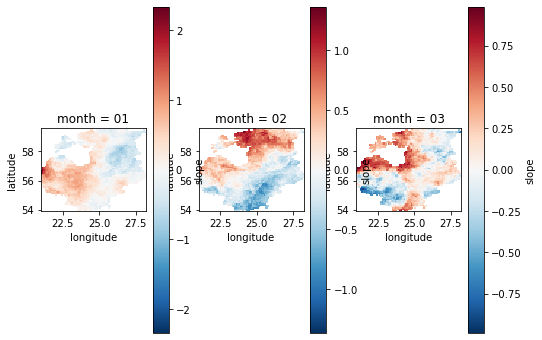

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(8, 6))
for month, ax in zip(['01', '02', '03'], axes):
    month_ds = test_array.sel(month=month)
    month_ds['slope'].plot(ax=ax)
    ax.set_aspect('equal')